In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

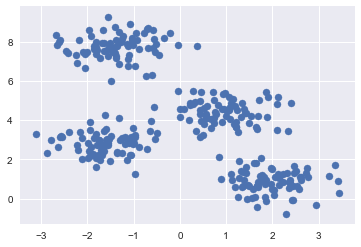

In [25]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50);

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

kmeans.fit(X)

y_kmeans = kmeans.predict(X)

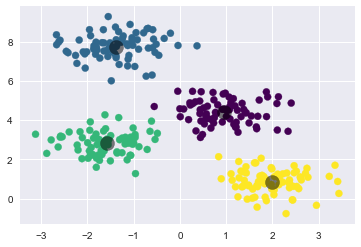

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

primeiro chute de centroids:


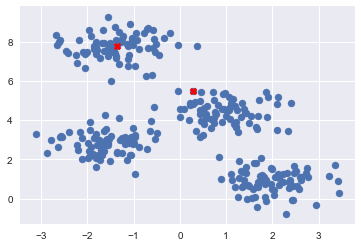


Interação: 1


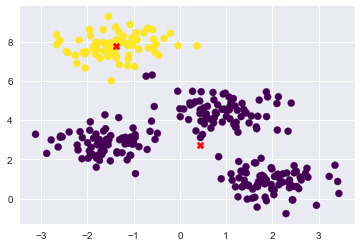


Interação: 2


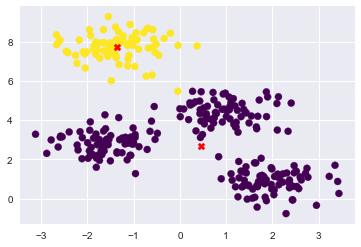


Interação: 3


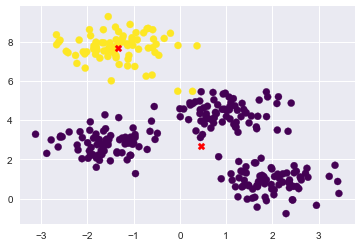


Interação: 4


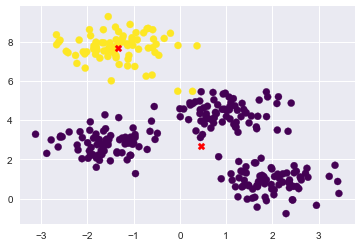

In [30]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    
    # 1. Escolhe os centros de forma aleatória.
    rng = np.random.RandomState(rseed)
    
    i = rng.permutation(X.shape[0])[:n_clusters] # sorteia i (i=numero de cluster procurados) observações
    
    centers = X[i] # Define essas observações sorteadas como os centros dos grupos.
    
    print('primeiro chute de centroids:')
    
    plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], marker='X', color='r')
    plt.show()
    
    interactions = 0
    
    while True:
        interactions += 1
        
        # 2. a funcao pairwise computa a menor distancia entre um ponto e um conjunto de pontos
        # Assim ela retornará a qual grupo pertence dado os centros recebidos:
        labels = pairwise_distances_argmin(X, centers)
        
        # 3. Depois de calcular os n grupos com a menor distância, vamos recacular os novos centros desses grupos.
        new_centers = []
        
        for i in range(n_clusters):
            center_i = X[labels == i].mean(0) # basicamente trazemos a média de cada eixo com labels iguais como centro do grupo.
            new_centers.append(list(center_i))
    
        new_centers = np.array(new_centers)
        
        print(f'\nInteração: {interactions}')
        plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis')
        plt.scatter(new_centers[:,0], new_centers[:,1], marker='X', color='r')
        plt.show()
        
        # 4 Vamos para o algoritmo quando os centros calculados não forem diferentes dos novos centros
        # passando a ideia de que conseguimos "convergir" o algoritmo para o menor valor de erro.
        if np.all(centers == new_centers):
            break
        centers = new_centers
            
    return centers, labels

centers, labels = find_clusters(X,2)

In [31]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

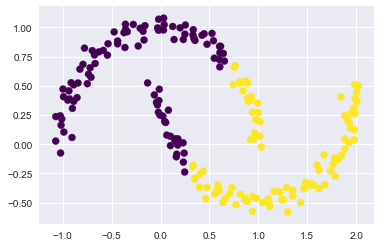

In [32]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');

# Qual algoritmo escolher sendo que não estudamos todas as ppossibilidades?

# Mesmo que não saibamos como funcionam por dentro podemos pegar a intuição de como eles trabalham ...

Automatically created module for IPython interactive environment


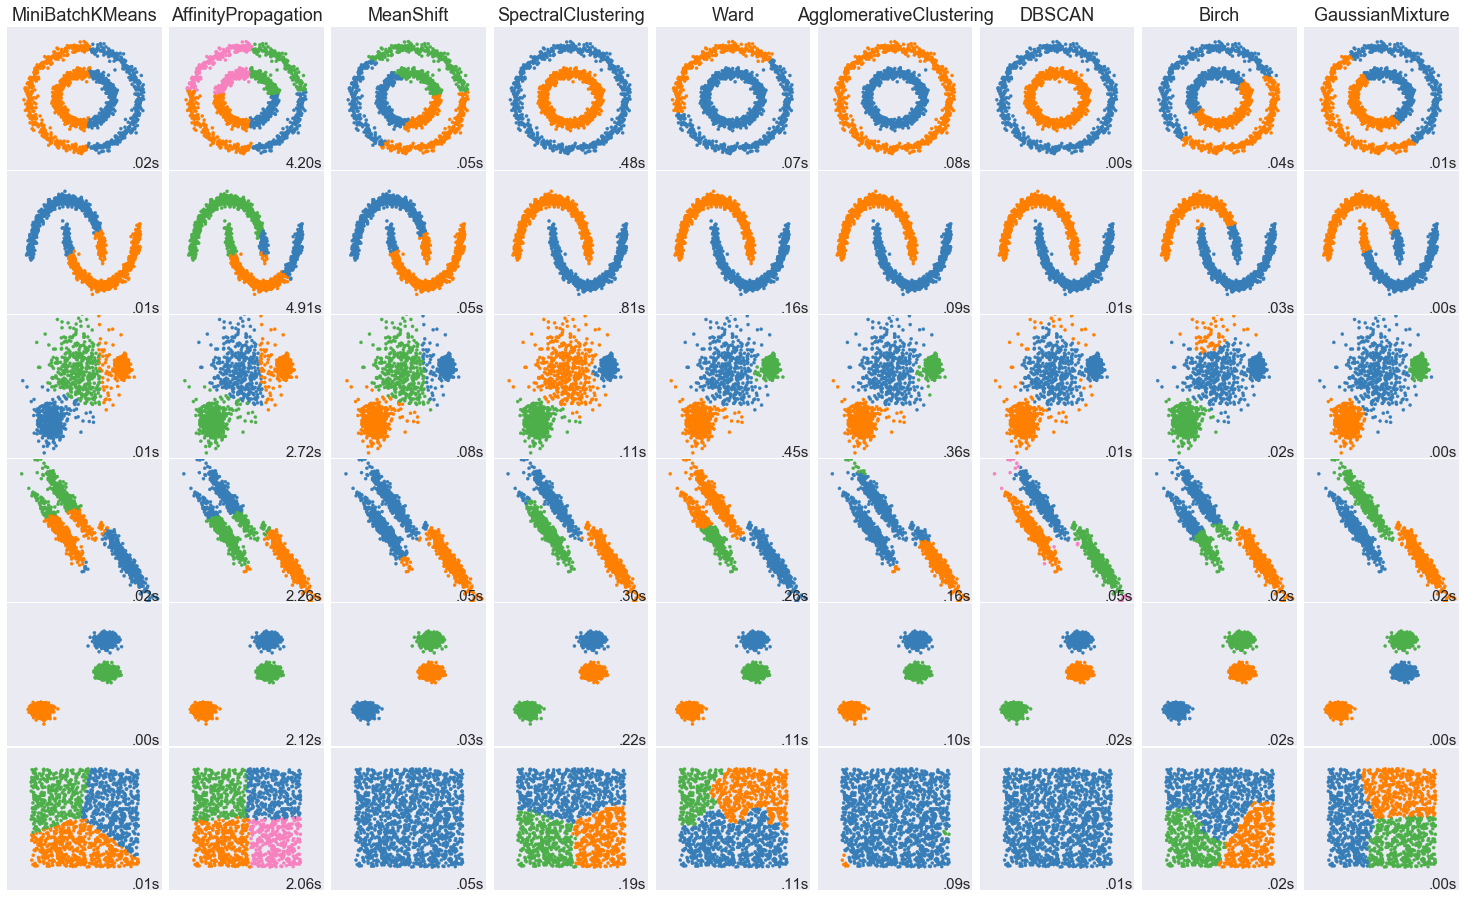

In [11]:
# código do sklearn: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html


print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

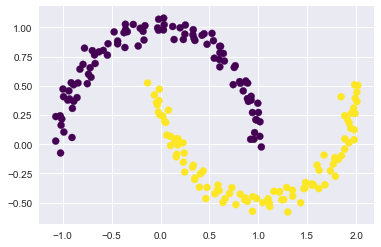

In [33]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')

labels = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

# Exemplo 2: k -seans para compactação de cores

Uma aplicação interessante de clusterização é a compactação de cores nas imagens. Por exemplo, imagine que você tenha uma imagem com milhões de cores. Na maioria das imagens, um grande número de cores não será usado e muitos dos pixels da imagem terão cores semelhantes ou até mesmo idênticas.

Por exemplo, considere a imagem mostrada na figura a seguir, que é do datasetsmódulo Scikit-Learn (para que isso funcione, você terá que ter o pillowpacote Python instalado).

C:\Users\sn3fru\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Users\sn3fru\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


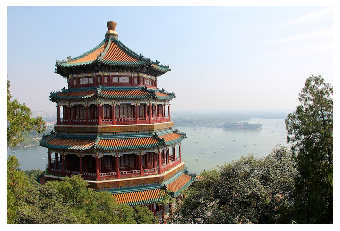

In [16]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

A imagem em si é armazenada em uma matriz tridimensional de tamanho (height, width, RGB), contendo contribuições vermelha / azul / verde como números inteiros de 0 a 255:

In [17]:
china.shape

(427, 640, 3)

Uma maneira de ver esse conjunto de pixels é como uma nuvem de pontos em um espaço de cores tridimensional. Vamos remodelar os dados [n_samples x n_features]e redimensionar as cores para que fiquem entre 0 e 1:

In [18]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Podemos visualizar esses pixels neste espaço de cor, usando um subconjunto de 10.000 pixels para eficiência:

In [19]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

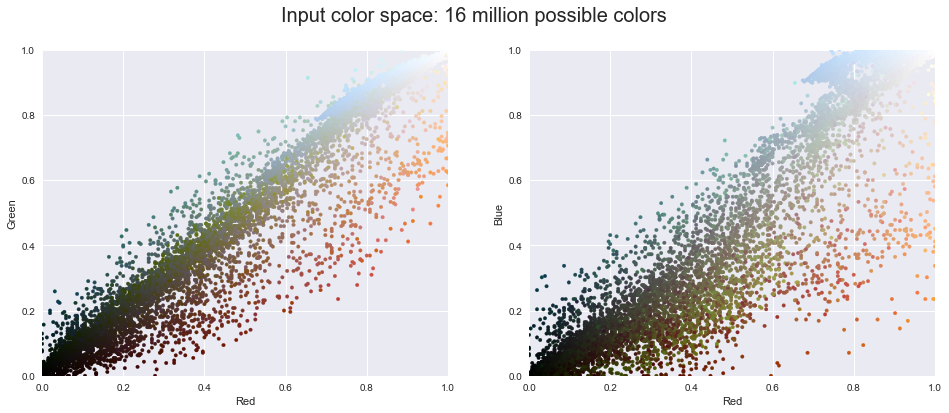

In [20]:
plot_pixels(data, title='Input color space: 16 million possible colors')


Agora, vamos reduzir esses 16 milhões de cores para apenas 16 cores, usando um cluster de k-means no espaço do pixel. Como estamos lidando com um conjunto de dados muito grande, usaremos o mini-lote k-means, que opera em subconjuntos dos dados para calcular o resultado muito mais rapidamente que o algoritmo padrão k-means

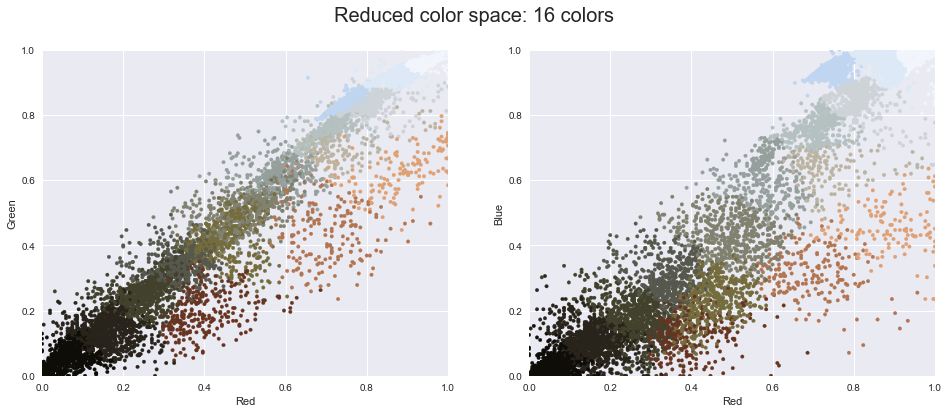

In [21]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

O resultado é uma nova coloração dos pixels originais, onde cada pixel recebe a cor de seu centro de cluster mais próximo. Plotar essas novas cores no espaço da imagem, em vez de no espaço do pixel, nos mostra o efeito disso: 

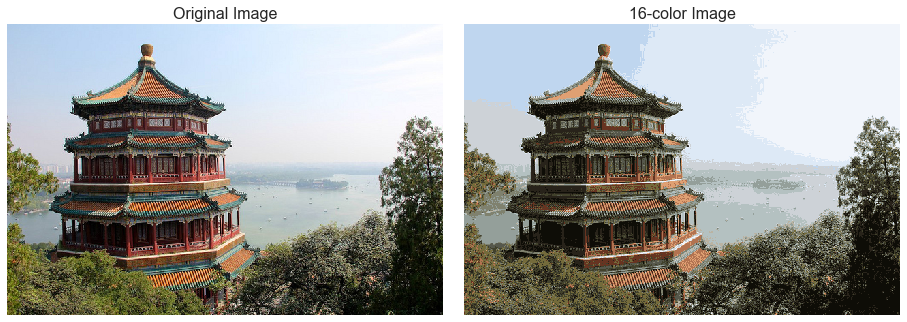

In [22]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Alguns detalhes são certamente perdidos no painel mais à direita, mas a imagem geral ainda é facilmente reconhecível. Esta imagem à direita alcança um fator de compressão de cerca de 1 milhão! Mas o exemplo mostra o poder de pensar fora da caixa com métodos não supervisionados como k-means.